In [5]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
#import pandas.util.testing as tm
#Eliminate libraries warnings
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
#Import libraries
import numpy as np

#import csv
#import requests
#import json
#import io
#import itertools


from pylab import rcParams
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from collections import Counter
import statsmodels.api as sm
import statsmodels.tsa as smt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

#Eliminate libraries warnings
import warnings
warnings.filterwarnings("ignore")


# Time series model

- To predict values in times, we apply **ARIMA**, one the most methods to forecasting along time.

- Or procedure will be supported by **Box Jenkins** Methodology.


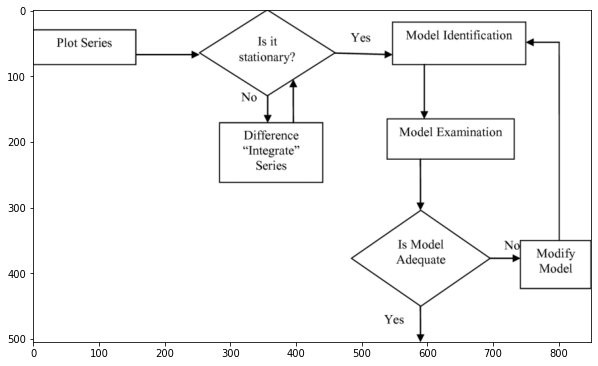

In [6]:
img = mpimg.imread('/Users/talitacoll/The Bridge/MMP/Box_Jenkins.png')
plt.figure(figsize=(10,20))
imgplot = plt.imshow(img)
plt.show();

In [7]:
#read dataframe
rute = '/Users/talitacoll/The Bridge/MMP/'
file = 'data.xlsx'
df = pd.read_excel(rute+file).set_index('index')

**At first our model will be tested ID representation in a global perspective**
- Change data to suit in time series model

In [8]:
#Sort by ID
df.sort_values('id').head(2)

,id,doc_type,transaction_date,order_type,order_date,quantity,unit_cost,extended_cost,item_type,product_id,serial_id,install_date,product_age,year,month,leadtime
index,,,,,,,,,,,,,,,,
129924,M000063,D1,2019-07-24,U1,2019-07-19,1,35.0,35.0,MOD,PB91E,SN0004938,2015-10-08,1380,2019,7,5
221907,M000063,D1,2021-01-19,U1,2020-12-27,1,35.0,35.0,MOD,P7298,SN0008493,2014-03-23,2471,2020,12,23


In [9]:
#Detecting insigfnicants ID dor the model
print('The dataframe has in total', df.id.value_counts().sum(),'records. From the total,',
      (df.id.value_counts()>=4).sum(),'items has at least 4 records, how we have 48 months \n'
      'of history, we would like to model only items that has been used at least 1 time per \n'
      'year, so we are going to reduce data only for ítems with more than 4 records.')

The dataframe has in total 46939 records. From the total, 1049 items has at least 4 records, how we have 48 months 
of history, we would like to model only items that has been used at least 1 time per 
year, so we are going to reduce data only for ítems with more than 4 records.


In [10]:
#Firstly we will make trains only based in IDs count
dfi = df[['id','order_date']]
dfi.head(2)

,id,order_date
index,,
21592,S04ECF605,2021-12-11
21593,S03D2C47C,2021-12-02


In [11]:
#Indexing by time to be use in time series
dfi.set_index('order_date',inplace=True)

In [12]:
#Using the library collection Counter to select only items that has at least 4 records
counts = Counter(dfi.id)
dfi = dfi[dfi.id.isin([key for key in counts if counts[key] >= 4])]
dfi.shape

(45363, 1)

**Reshape a dataset to start the model**

In [13]:
#A month counter by month to our model
general = dfi['id'].resample('M').count()

In [14]:
general

order_date
2018-01-31     944
2018-02-28     936
2018-03-31     973
2018-04-30     905
2018-05-31     757
2018-06-30     978
2018-07-31     881
2018-08-31     727
2018-09-30     798
2018-10-31     879
2018-11-30     893
2018-12-31     942
2019-01-31     795
2019-02-28     792
2019-03-31     906
2019-04-30     879
2019-05-31     932
2019-06-30     985
2019-07-31    1142
2019-08-31     764
2019-09-30     863
2019-10-31     918
2019-11-30     817
2019-12-31     823
2020-01-31     827
2020-02-29     923
2020-03-31     871
2020-04-30     505
2020-05-31     593
2020-06-30     911
2020-07-31    1063
2020-08-31     896
2020-09-30    1007
2020-10-31    1127
2020-11-30    1208
2020-12-31    1239
2021-01-31    1216
2021-02-28    1238
2021-03-31    1181
2021-04-30     956
2021-05-31    1007
2021-06-30    1088
2021-07-31    1103
2021-08-31    1008
2021-09-30    1056
2021-10-31    1155
2021-11-30    1023
2021-12-31     933
Freq: M, Name: id, dtype: int64

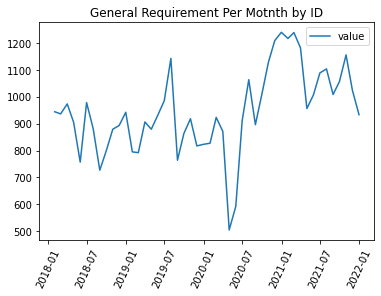

In [15]:
#Plot the general perspective
plt.title('General Requirement Per Motnth by ID')
#General movement
plt.plot(general, label='value')
plt.legend()
plt.xticks(rotation=65);

#Decomposing the Additive Model in 4 components:

1 - General observations

2 - Secular trend

2 - Seasonal variation

4 - Residual variation

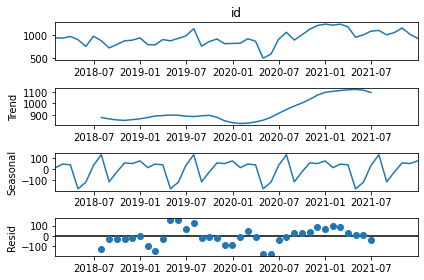

In [16]:
gen = seasonal_decompose(general, model="additive")
gen.plot();

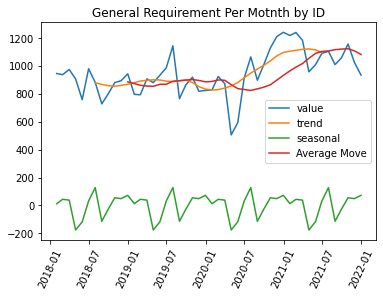

In [17]:
# A flot to have a general perspective
# DataSet Original Plot
plt.title('General Requirement Per Motnth by ID')
#General movement
plt.plot(general, label='value')
#Secular Trend
plt.plot(gen.trend, label='trend')
#Seasoanl pattern
plt.plot(gen.seasonal, label='seasonal')
#Moving average trend from 12 months from start observations
plt.plot(general.rolling(window=12).mean(), label='Average Move')
plt.legend()
plt.xticks(rotation=65);

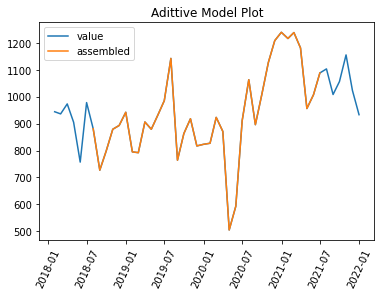

In [18]:
plt.title('Adittive Model Plot')
#General movement
plt.plot(general, label='value')
plt.plot(gen.trend + gen.seasonal + gen.resid, label='assembled')
plt.legend()
plt.xticks(rotation=65);

*Besides in EDA we detected a increase trend in 2020, in this plot is clear exactly the moment where Covid 19 started to afect consumption.*

**Decompose only Seasonal Pattern to check if there is some cycle**

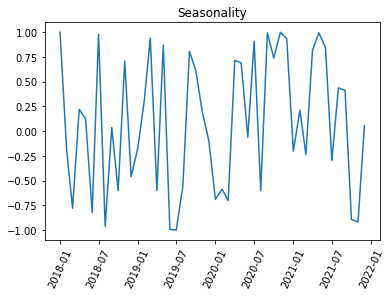

In [19]:
# np.sin to detect angle in radians
x = np.sin(general.values)
#A DataFrame including the whole dataset in monthly frecuence.
y = pd.DataFrame(x,index=pd.date_range("01/01/2018", periods=48, freq="MS"))
plt.title('Seasonality')
plt.plot(y)
plt.xticks(rotation=65);

*According to previous graph there´s no some clearly pattern*

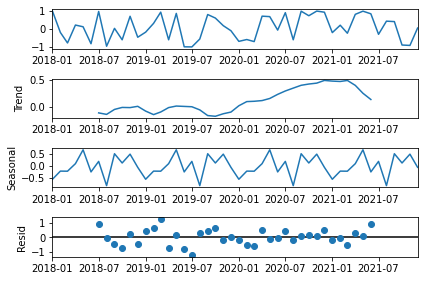

In [20]:
# Decomposing the seasonal pattern
seasonal_decompose(y).plot();

*- Removing the noise, the seasonal pattern is clear.*

*- We can se the pattern has a significative decrease in European Summer Hollidays and after Christimas/Kings season.*

# -Identify stationarity


**ADFuller test**

We are going to use the ADFuller test to check if stationarity exists in the series or not:

- Null hypothesis: No Stationarity exists in the series.

- Alternative hypotesis: Stationarity exists in the series.



In [21]:
#Create 2 arrays, on clearly stationary and other one not, only to test functions.
t1 = pd.DataFrame([1,2,3,1,2,3,1,2,3])
t2 = pd.DataFrame([1,9,5,7,68,751,688,17])

In [25]:
#Check if the general set is stationary.
def adfuller_test(data):
    results=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags used','Number of observations']
    for v,l in zip(results,labels):
        print(l+':'+str(v))
    if results[1] <=.05:
        print('P value is less than 0.05, that means we can reject the null hypothesis,\n'
                  'so we conclude that series is stationary.')
    else:
         print('P value shows we can´t reject the Null Hypotesis, that means the series is not stationary.')
    return

In [26]:
print(adfuller_test(t1),adfuller_test(t2))

ADF Test Statistic:-1985276781053697.5
p-value:0.0
#Lags used:2
Number of observations:6
P value is less than 0.05, that means we can reject the null hypothesis,
so we conclude that series is stationary.
ADF Test Statistic:-2.2203368140423247
p-value:0.1989473324072254
#Lags used:1
Number of observations:6
P value shows we can´t reject the Null Hypotesis, that means the series is not stationary.
None None


In [27]:
#Apply the adfuller test in the train set
adfuller_test(general)

ADF Test Statistic:-1.8071493411014237
p-value:0.37691806560754193
#Lags used:2
Number of observations:45
P value shows we can´t reject the Null Hypotesis, that means the series is not stationary.


*The set is* **not** *stationary, so we have to detect the* **Integrated Difference**.

# - Identify ARIMA orders
$f = {p,d,q}$

**- Difference (I)**

How we checked that our train is not stationary, we have to find the integrated diferrence, for 1st and 2nd order.



In [36]:
#Find difference for first and second order
def plot_diff(data):
    if adfuller(data)[1]<=0.05:
        print('P value is less than 0.05, that means we can reject the null hypothesis,\n'
                  'so we conclude that series is stationary.')
        d=0
    else:
        for i in range(1,3):
            diff = data.diff(i)[i:]
        if adfuller(data.diff().dropna())[1]<0.05:
            d=1
            print(f'P_value:{adfuller(data.diff().dropna())[1]},the order for model is {d}.')
        elif adfuller(data.diff().diff().dropna())[1]<0.05:
            print(f'P_value:{adfuller(data.diff().diff().dropna())[1]},the order for model is {d}.')
            d=2
        else:
            print("ERROR!!!!")
    return

**Based on P-Value for first and second-order, we will pick the first-order for I.**

$ d=1 $

In [37]:
plot_diff(general)

P_value:9.768367820613255e-12,the order for model is 1.


$ d=1$

**- AutoRegression Detection(AR)**


AR(1) model:

$y_t=a_1 y _t-_1 + €_t$

AR(2) model:

$y_t=a_1 y _t-_1 + €_t + y_t=a_2 y _t-_2 + €_t$


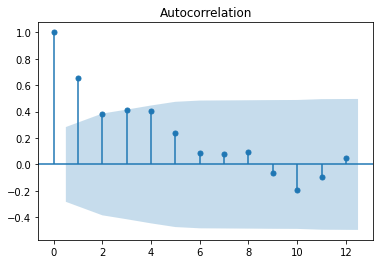

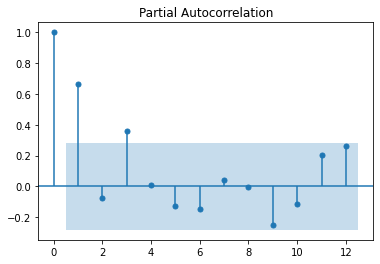

In [24]:
#Plot autocorrelation and partial Autorrelagion plot to identify the order in 12 months
plot_acf(general, lags=12)
plot_pacf(general, lags=12);

*Both graphs we can identify the Autorregression of order 1.*

- To find the best AutoRegression and Move Average orders combination, we will use the the Bayesian Information Critetion (BIC)

**Move Average (MA) dectetion**




MA(1)

$y_t=m_1€_t-_1 + €_t$

MA(2)

$y_t=m_1€_t-_1 + €_t + m_2€_t-_2 + €_t$

Is not interesting to have a general move average, however, if we study in anual window, this information can be more interested.

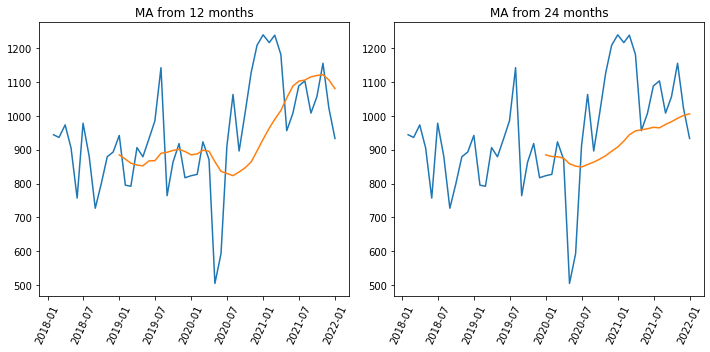

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('MA from 12 months')
plt.plot(general, label='Service Counts')
plt.plot(general.rolling(window=12).mean(), label='Move Average')
plt.xticks(rotation=65)


plt.subplot(1, 2, 2)
plt.title('MA from 24 months')
plt.plot(general, label='Service Counts')
plt.plot(general.rolling(window=24).mean(), label='Move Average')
plt.xticks(rotation=65)

plt.tight_layout()

**To find the best order combination between AR and MA in our model, we are going to use the follow function**

In [26]:
#we are going to apply ARIMA model to find the best order
def getpq(data):
    #We have identified previously the Integrated Difference
    d=1
    #Maximus interations will be the set divided in 12, what means we are making 4 iterations
    p_max = int(len(data) / 12)
    q_max = int(len(data) / 12)
    matrix_bic = []
    for p in range(p_max +1):
        aux= []
        for q in range(q_max+1):
            try:
                model = ARIMA(data, order=(p,d,q)).fit(disp=False)
                aux.append(model.bic)
            except:
                aux.append(None)
        matrix_bic.append(aux)    
    matrix_bic = pd.DataFrame(matrix_bic)
    #Asigning p and q to matrix in order to find the best(lowest) relation.
    p,q = matrix_bic.stack().astype('float64').idxmin()
    print(matrix_bic)
    #Plot a heatmap to identify the best set of orders.
    #The darkest is the section in the grap, the lowest is the order and the best is the correclation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(matrix_bic,
                 mask=matrix_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
    ax.set_title('BIC');
    return p,q

            0           1           2           3           4
0  599.351247  600.331191  597.185808  600.313635  604.729402
1  602.602225  598.405763  600.073226  602.784961  608.326509
2  596.366306  599.881765         NaN         NaN  604.275517
3  599.810496  601.062750         NaN  624.670692         NaN
4  603.583468  607.469147  607.466532  613.850319  609.157922


(2, 0)

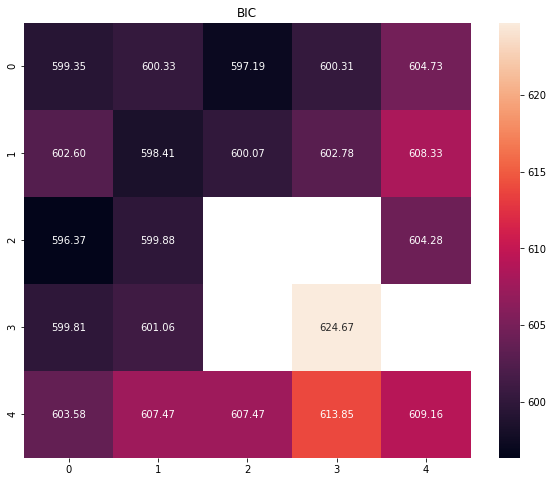

In [27]:
getpq(general)

*The best orders combination for general dataset results p=2,d=1,q=0*

**Start to model the train set based on orders=(2,1,0)**

In [40]:
# Confirm if the previous combination us the best for our model, including the 'I'
def getpdq(data):
    if adfuller(data)[1]<=0.05:
        d=0
    else:
        for i in range(1,3):
            diff = data.diff(i)[i:]
            if adfuller(data.diff().dropna())[1]<0.05:
                d=1
            elif adfuller(data.diff().diff().dropna())[1]<0.05:
                d=2
    #Maximus interations will be the set divided in 12, that means, if the lengt is 36, the system will do 3 iteratios        
    p_max = int(len(data) / 12)
    q_max = int(len(data) / 12)
    matrix_bic = []
    for p in range(p_max +1):
        aux= []
        for q in range(q_max+1):
            try:
                model = ARIMA(data, order=(p,d,q)).fit(disp=False)
                aux.append(model.bic)
            except:
                aux.append(None)
        matrix_bic.append(aux)    
    matrix_bic = pd.DataFrame(matrix_bic)
    #Asigning p and q to matrix in order to find the best(lowest) relation.
    p,q = matrix_bic.stack().astype('float64').idxmin()
    print(matrix_bic)
    #Plot a heatmap to identify the best set of orders.
    #The darkest is the section in the grap, the lowest is the order and the best is the correclation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(matrix_bic,
                 mask=matrix_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
    ax.set_title('BIC');
    return p,d,q

In [41]:
#Definy the train as 75% from dataset and 25% fot test
tsize = int(len(general)*.75)
train = general.iloc[:tsize]
test = general.iloc[tsize:]

            0           1           2           3
0  452.716421  453.568192  452.854313  456.254532
1  455.619555  454.008069  455.971650         NaN
2  452.135308  455.228610  458.557698         NaN
3  455.139552  457.985069         NaN         NaN


(2, 1, 0)

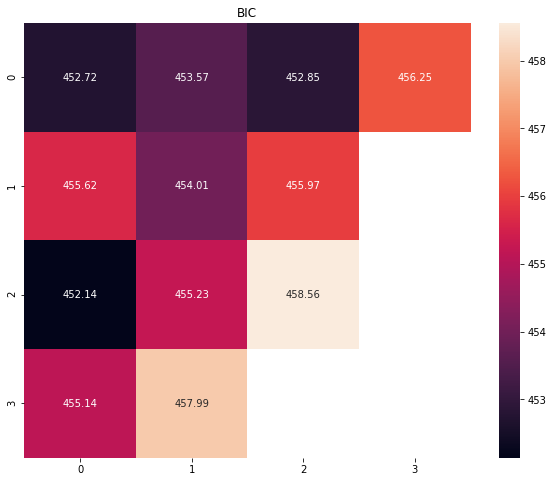

In [42]:
getpdq(train)

In [38]:
#Using the previous combination for fit our model
model = ARIMA(general, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.id   No. Observations:                   47
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -290.483
Method:                       css-mle   S.D. of innovations            116.381
Date:                Sun, 30 Jan 2022   AIC                            588.966
Time:                        18:43:42   BIC                            596.366
Sample:                    02-28-2018   HQIC                           591.751
                         - 12-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1356     10.714      0.106      0.916     -19.863      22.134
ar.L1.D.id    -0.1695      0.131     -1.296      0.195      -0.426       0.087
ar.L2.D.id    -0.4378      0.129     -3.394      0.0

*It seems the combiantion is correct, P Value for 2 laps is low, so this combination is aceptable.*

In [33]:
#This function generate the difference to be used in the next step
def difference(train,interval = 1):
    diff = list()
    for i in range (interval, len(train)):
        value = train[i] - train[i - interval]
        diff.append(value)
    return diff

#This function will give the original data
def inverse_difference(history,predict,interval=-1):
     return predict + history[-interval]

In [34]:
#we are going to create a history to stock information
history = [x for x in train]

#List to stock predictions
predictions = list()

#Fit the set
for t in range(len(test)):

        #Differnce the data
    period = 4 #Our dataset has 4 years, so we are working with 4
    diff = difference(history,period)
            #Create a model with history set
    model=ARIMA(diff, order=(2,0,0))#difference is 0, because we made the difference previously
            #Training the model
    model_fit = model.fit(disp=0)
            #Forecast predicted by model
    fc = model_fit.forecast()[0]
            #Forecat receive the inverse value
    fc = inverse_difference(history, fc, period)
            #Adding the forecat value in the forecast list
    predictions.append(fc)
            #Current value to check with the test set
    current_value = test[t]
            #Adding the current value in the history
    history.append(current_value)



In [35]:
#A DataFrame to stock results
results = pd.DataFrame(test)
results['forecast']=[x[0] for x in list(predictions)]
results['forecast']=results['forecast'].astype(int)
results

,id,forecast
order_date,,
2021-01-31,1216,1195
2021-02-28,1238,1247
2021-03-31,1181,1277
2021-04-30,956,1234
2021-05-31,1007,1065
2021-06-30,1088,1141
2021-07-31,1103,1108
2021-08-31,1008,921
2021-09-30,1056,1046


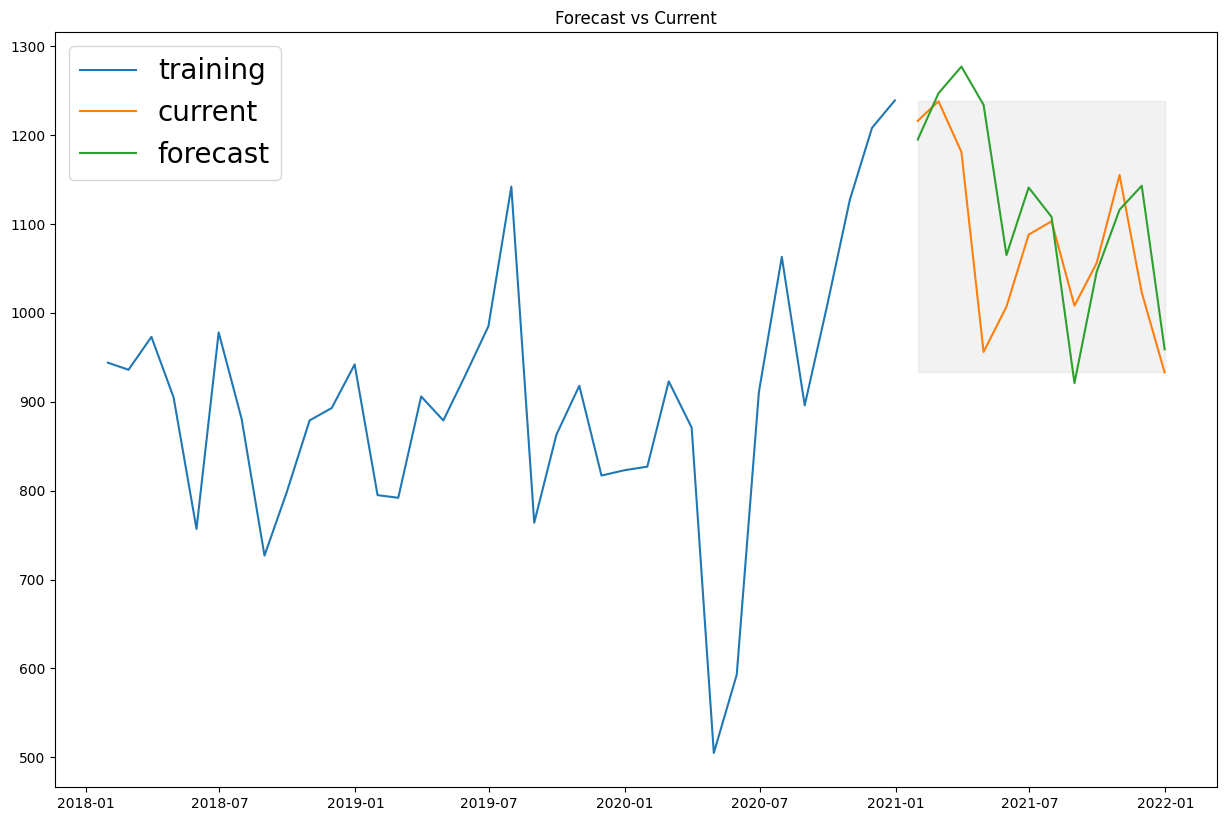

In [39]:
#plot previous results
fc_series = pd.Series(results.index)
lower_series = pd.Series(min(test))
upper_series = pd.Series(max(test))
plt.figure(figsize=(15,10),dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='current')
plt.plot(results.forecast, label='forecast')
plt.fill_between(results.index,lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Current')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [40]:
def kpi(pred, test):
        dif = pred - test

        #Mean Percentage Error (MPE)
        mpe = np.mean((dif)/test)   

        #Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs(dif)/np.abs(test))

        #Mean Absolute Error (MAE)
        mae = np.mean(np.abs(dif))

        #Root Mean Square Error(RMSE)
        rmse = np.sqrt(mean_squared_error(test,predictions))

        #Correlation
        corr = np.corrcoef(pred, test)[0,1]

        #MinMax
        mins = np.amin(np.hstack([pred[:,None], 
                                  test[:,None]]), axis=1)
        maxs = np.amax(np.hstack([pred[:,None], 
                                  test[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)            

        #Autocorrelation Function (from statsmodel)
        acf1 = acf(dif)[1]



        return({'mpe':mpe,'mae': mae, 
                'mape': mape, 'rmse':rmse, 'acf1':acf1,
                'corr':corr, 'minmax':minmax})
fc, se, conf = model_fit.forecast(12, alpha=0.05)


In [41]:
kpi(results.forecast, results.id)

{'mpe': 0.04071240998641649,
 'mae': 66.83333333333333,
 'mape': 0.06518160855100981,
 'rmse': 99.09042563050139,
 'acf1': 0.2539435981819961,
 'corr': 0.6054045152767572,
 'minmax': 0.05766783334507031}

*KPIs prove the model works and results are very suitable.*

In [42]:
residuals=[test[i]-predictions[i] for i in range(len(test))]

In [43]:
#Create a DataFrame for residuals from model
residuals = pd.DataFrame(model_fit.resid)
residuals.describe()

,0
count,43.000000
mean,2.142892
std,149.538662
min,-350.963219
25%,-87.027888
50%,11.962014
75%,102.847094
max,277.173386


                0
count   43.000000
mean     2.142892
std    149.538662
min   -350.963219
25%    -87.027888
50%     11.962014
75%    102.847094
max    277.173386


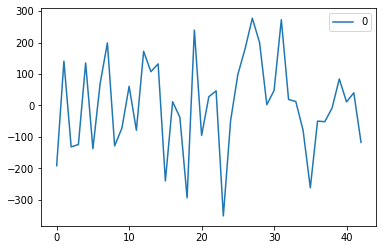

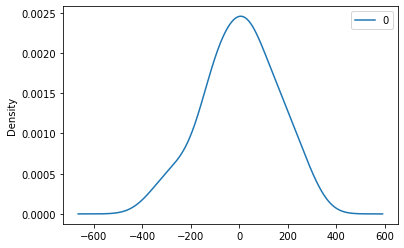

In [44]:
#Plot 
residual = pd.DataFrame(model_fit.resid)
residual.plot();
residual.plot(kind='kde');
print(residual.describe())

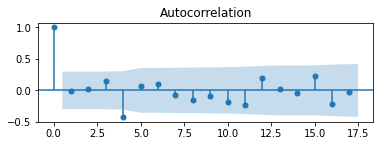

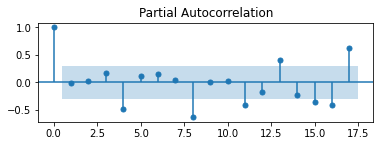

In [45]:
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())

plt.figure()
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

*We can´t detect a pattern in residual plot, so it can support evidences that the models works properly*

# Conclusion

- Based in evidences as KPIs, residuals analysis we can conclude the model works properly.
- In a Global peerspective, the model works around 93,5% of accurancy.
- Next step is apply the model for each PN#
